In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pygsp as pygsp

from tqdm import tqdm
import numpy as np
import random

In [6]:
# Trace builiding code
class Trace:
    def __init__(self):
        self.calls = []

class Node_info:
    def __init__(self, num_id, n_type):
        self.num_id = num_id
        self.n_type = n_type

class Call:
    def __init__(self, traceid, timestamp, rpcid, um, dm, rpctype, interface, rt):
        self.traceid = traceid
        self.timestamp = timestamp
        self.rpcid = rpcid
        self.um = um
        self.dm = dm 
        self.rpctype = rpctype
        self.interface = interface
        self.rt = rt
    def string(self):
        return self.traceid + "," + str(self.timestamp) + "," + self.rpcid + "," + self.um + "," + self.dm + "," +\
            self.rpctype + "," + self.interface + "," + str(self.rt)

def csv_to_df(file: str):
    df = pd.read_csv(file)
    return df

def extract_traceid_rows(df, tid):
    f_df = df[df['traceid'] == tid]
    tid_calls = [
        Call(
            str(row.traceid), 
            int(row.timestamp), 
            str(row.rpcid), 
            str(row.um), 
            str(row.dm), 
            str(row.rpctype), 
            str(row.interface), 
            int(row.rt)
        ) for row in f_df.itertuples(index=False)
    ]
    return tid_calls
def plot_agg_graphnx(G, pos=None, edge_width=0.8, node_size=20, alpha=0.55, title=""):
    """
    Used to plot aggregated graph, creates a node type to color mapping
    pos : dict, optional
        A dictionary with nodes as keys and positions as values.
        If not provided, will use spring layout.

    """
    colors = []
    for node in G.nodes():
        n_type = G.nodes[node]['type'] 
        if n_type[:2] == "db":
            colors.append("green")
        else:
            colors.append("blue")
    if pos is None:
        pos = nx.spring_layout(G)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d' if len(next(iter(pos.values()))) == 3 else None)
    ax.axis("off")
    ax.set_title(title)

    # Draw edges and nodes
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=alpha, width=edge_width)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=node_size, alpha=alpha, node_color=colors)

    fig.tight_layout()
    plt.savefig("test.png", format='png')
    plt.close(fig)

    return fig


def plot_colored_graphnx(G, sf_list, sl_list, pos=None, edge_width=0.8, node_size=20, alpha=0.55, title=""):

    if pos is None:
        pos = nx.spring_layout(G)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d' if len(next(iter(pos.values()))) == 3 else None)
    ax.axis("off")
    ax.set_title(title)

    # Draw edges and nodes
    options = {"node_size": node_size, "alpha": alpha}
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=alpha, width=edge_width)
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=sf_list, node_color="tab:green", **options) # statefull == green
    nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=sl_list, node_color="tab:blue", **options) # stateless == blue

    fig.tight_layout()
    plt.savefig("test.png", format='png')
    plt.close(fig)

    return fig



In [7]:
def get_dg_initial_node(G):
    initial_nodes = []
    for node, in_deg in G.in_degree():
        if in_deg == 0:
            initial_nodes.append(node)
    print("Initial nodes: ", initial_nodes)
    return initial_nodes

def get_dg_unique_nodes(G):
    res = set(G.nodes)
    print("Num of nodes: ", len(res))
    return res


def node_type_map_gen(G, all_sf_nodes, all_sl_nodes, sf_cats = 0):
    '''
    Generates node to type mapping
    sf_cats: is the number of categories to increase for statefull nodes
    '''
    node_type_map = {}
    for sf_node in all_sf_nodes:
        #randomly assigning the statefull node to a category
        cat = "db" + str(random.randint(0, sf_cats))
        node_type_map[sf_node] = cat
    for sl_node in all_sl_nodes:
        node_type_map[sl_node] = "mc"
    
    for node in G.nodes():
        if node not in node_type_map:
            node_type_map[node] = "mc"
            
    return node_type_map

def sf_sl_node_extraction(G):
    """
    Extracts lists of sf snd sl nodes
    """
    sf_nodes = []
    sl_nodes = []
    for node in G.nodes():
        n_type = Gs.nodes[node]['type'] 
        if n_type[:2] == "db":
            sf_nodes.append(node)
        else:
            sl_nodes.append(node)
    return sf_nodes, sl_nodes
    

In [8]:
# types :  ['userDefined', 'db', 'http', 'mq', 'rpc', 'mc']
# Extract to dataframe
df = csv_to_df("./MSCallGraph_0.csv")

# Extract all tids
tids_list = df['traceid'].unique()
print("Num of tids: ", len(tids_list))

Num of tids:  130512


  1%|          | 999/130512 [04:05<8:51:23,  4.06it/s]


Num of nodes:  1058
Num of sf nodes:  300
Num of sl nodes:  740


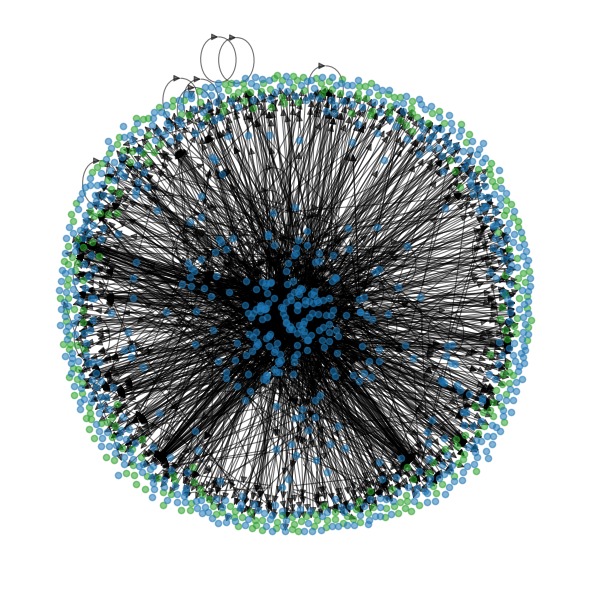

In [9]:
"""
Graph Building
"""

ctr = 0
all_edges = []
all_sl_nodes = []
all_sf_nodes = []
all_nodes = []
rpc_types = []
for i in tqdm(range(len(tids_list))):
    # if i in [0,1,2]:
    #     continue
    ctr += 1
    tid_calls = extract_traceid_rows(df, tids_list[i])
    for call in tid_calls:
        all_edges.append([call.um, call.dm])
        all_nodes.append(call.um)
        all_nodes.append(call.dm)
        # print(call.rpctype)
        # rpc_types.append(call.rpctype)
        if call.rpctype == "db":
            all_sf_nodes.append(call.dm)
        else: 
            all_sl_nodes.append(call.dm)
    # print("len tid:", len(tid_calls))
    if ctr == 1000:
        break
all_nodes = list(set(all_nodes))
print("Num of nodes: ", len(all_nodes))
all_sf_nodes = list(set(all_sf_nodes))
print("Num of sf nodes: ", len(all_sf_nodes))
all_sl_nodes = list(set(all_sl_nodes))
print("Num of sl nodes: ", len(all_sl_nodes))

# unique_rpcs = list(set(rpc_types))
# print("types : ", unique_rpcs)

G = nx.DiGraph()
G.add_edges_from(all_edges)
plot_colored_graphnx(G, all_sf_nodes, all_sl_nodes)


Num of sf nodes:  190
Num of sl nodes:  222


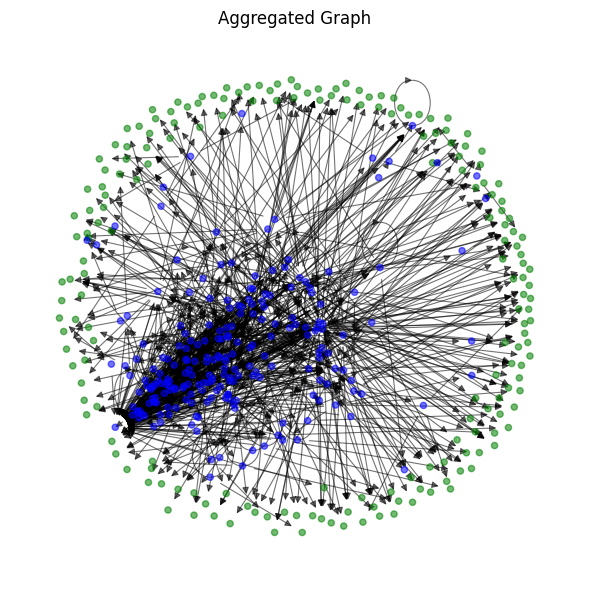

In [10]:
"""
SNAP Aggregation
"""

node_type_map = node_type_map_gen(G, all_sf_nodes, all_sl_nodes, 300)
# Define the node attributes to aggregate on
nx.set_node_attributes(G, node_type_map, 'type')
node_attributes = ("type",)

# Perform the snap aggregation
Gs = nx.snap_aggregation(G, node_attributes=node_attributes)

sf_nodes, sl_nodes = sf_sl_node_extraction(Gs)
print("Num of sf nodes: ", len(sf_nodes))
print("Num of sl nodes: ", len(sl_nodes))

# Plot the aggregated graph
plot_agg_graphnx(Gs, title="Aggregated Graph")

In [13]:



def ksnap_agg_graph(G, k, sf_cats):
    node_type_map = node_type_map_gen(G, all_sf_nodes, all_sl_nodes, sf_cats)
    # Define the node attributes to aggregate on
    nx.set_node_attributes(G, node_type_map, 'type')
    node_attributes = ("type",)
    while k > 0:
        k = k - 1
        print(k)
        G = nx.snap_aggregation(G, node_attributes=node_attributes)
        plot_agg_graphnx(G, title="Aggregated Graph")
    return G

def ksnap_until_thresh(G, all_sf_nodes, all_sl_nodes, sf_cats, min_nodes):
    print(f"Number of nodes in origianl graph = {len(G)}")
    node_type_map = node_type_map_gen(G, all_sf_nodes, all_sl_nodes, sf_cats)
    # Define the node attributes to aggregate on
    nx.set_node_attributes(G, node_type_map, 'type')
    node_attributes = ("type",)
    iter = 0
    exit_arr = []
    while len(G) > min_nodes:
        G = nx.snap_aggregation(G, node_attributes=node_attributes)
        sf_nodes, sl_nodes = sf_sl_node_extraction(G)
        node_type_map = node_type_map_gen(G, sf_nodes, sl_nodes, sf_cats)
        nx.set_node_attributes(G, node_type_map, 'type')
        node_attributes = ("type",)
        iter += 1
        num_nodes = len(G)
        exit_arr.append(num_nodes)
        # Logic to exit 
        if len(exit_arr) == 5 and sum(exit_arr) == 5*num_nodes:
            return G
        if len(exit_arr) == 5:
            exit_arr = []
        print(f"Iteration {iter}: Number of nodes = {num_nodes}")
        
    return G

Number of nodes in origianl graph = 1058
Iteration 1: Number of nodes = 248
Iteration 2: Number of nodes = 238
Iteration 3: Number of nodes = 232
Iteration 4: Number of nodes = 227
Iteration 5: Number of nodes = 222
Iteration 6: Number of nodes = 222
Iteration 7: Number of nodes = 217
Iteration 8: Number of nodes = 216
Iteration 9: Number of nodes = 214
Iteration 10: Number of nodes = 212
Iteration 11: Number of nodes = 211
Iteration 12: Number of nodes = 211
Iteration 13: Number of nodes = 211
Iteration 14: Number of nodes = 208
Iteration 15: Number of nodes = 208
Iteration 16: Number of nodes = 208
Iteration 17: Number of nodes = 205
Iteration 18: Number of nodes = 204
Iteration 19: Number of nodes = 203
Iteration 20: Number of nodes = 203
Iteration 21: Number of nodes = 203
Iteration 22: Number of nodes = 201
Iteration 23: Number of nodes = 201
Iteration 24: Number of nodes = 200
Iteration 25: Number of nodes = 198
Iteration 26: Number of nodes = 198
Iteration 27: Number of nodes = 

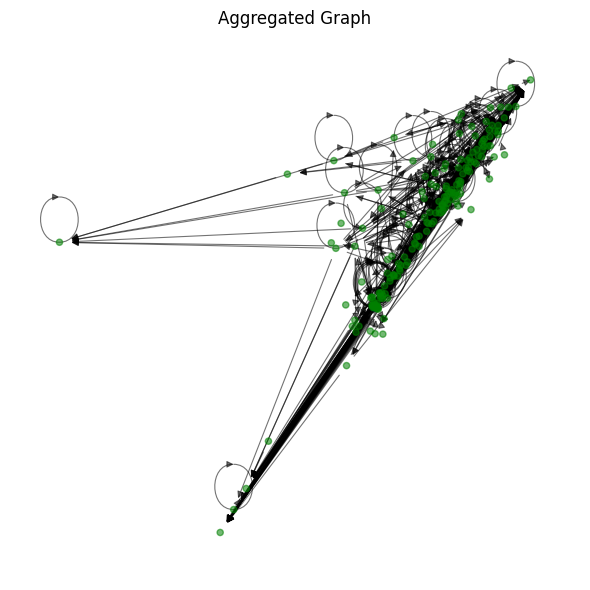

In [14]:
"""
K-SNAP Aggregation
"""
# G = nx.DiGraph()
# G.add_edges_from(all_edges)
# plot_colored_graphnx(G, all_sf_nodes, all_sl_nodes)
# Gk = ksnap_agg_graph(G, k=10, sf_cats=25)
# plot_agg_graphnx(Gk, title="Aggregated Graph")

Gk = ksnap_until_thresh(G, all_sf_nodes, all_sl_nodes, sf_cats=27, min_nodes=100)
sf_nodes, sl_nodes = sf_sl_node_extraction(Gs)
print("Num of sf nodes: ", len(sf_nodes))
print("Num of sl nodes: ", len(sl_nodes))
plot_agg_graphnx(Gk, title="Aggregated Graph")



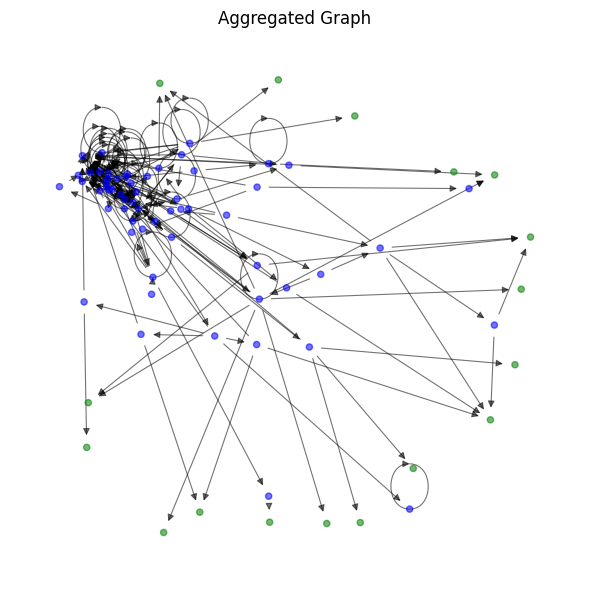